In [55]:
import numpy as np
import matplotlib.pyplot as plt
import torch
np.random.seed(0)
import math
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [56]:
def generate_data(length):
    num_samples = length
    count_ones = 0
    X = np.zeros((num_samples, 2))
    y = np.zeros(num_samples,)
    for i in range(num_samples):
        X[i,0] = np.random.uniform(0,1) # sample first distribution from random normal distribution
        X[i,1] = (np.random.uniform(0,1))
        if(X[i,1] > 0.5 and count_ones < 2):
            X[i,1] = 1.0
            count_ones += 1
            y[i] = y[i-1] + X[i,0]
        else:
            X[i,1] = 0.0
            y[i] = y[i-1] 
    return X.astype(np.double),y.astype(np.double)

In [57]:
# generate dataset type sequence
X_data = []
y_data = []
for i in range(3000):
    length = np.random.randint(4, 10)
    X, y = generate_data(length)
    X_data.append(torch.from_numpy(X).double())
    y_data.append(y)

In [58]:
# do a train test split of the data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)

In [59]:
example = X_data[1]
l = torch.nn.Linear(2, 10, dtype=torch.float64)
example_h = torch.zeros(2,dtype = torch.float64)
print(l(example_h).shape)
l(example[0,:]).shape

torch.Size([10])


torch.Size([10])

In [60]:
class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = torch.nn.Linear(input_size, hidden_size, bias=True)
        self.h2h = torch.nn.Linear(hidden_size, hidden_size, bias=True)
        self.h2o = torch.nn.Linear(hidden_size, output_size, bias=True)
        self.hidden_state = torch.zeros(self.hidden_size, dtype=torch.float64)
        self.MAX_TIME_STEPS = 15
        self.MIN_TIME_STEPS = 3
        self.outputs = []
    def forward(self, input):
        #input shape = (num_ts,2)
        if(input.shape[0] > self.MAX_TIME_STEPS or input.shape[0] < self.MIN_TIME_STEPS):
            print("Input sequence length is sus")
            return None
        self.hidden_state = self.initHidden()
        self.outputs = []
        for i in range(input.shape[0]):
            self.hidden_state = torch.sigmoid(self.i2h(input[i,:]) + self.h2h(self.hidden_state))
            self.outputs.append(self.h2o(self.hidden_state))
            final_op = self.h2o(self.hidden_state)
        return final_op
    def initHidden(self):
        return torch.zeros(self.hidden_size, dtype = torch.float64)

In [61]:
net = RNN(2, 10, 1)
net = net.double()
print(net)

RNN(
  (i2h): Linear(in_features=2, out_features=10, bias=True)
  (h2h): Linear(in_features=10, out_features=10, bias=True)
  (h2o): Linear(in_features=10, out_features=1, bias=True)
)


In [62]:
print(net.parameters)

<bound method Module.parameters of RNN(
  (i2h): Linear(in_features=2, out_features=10, bias=True)
  (h2h): Linear(in_features=10, out_features=10, bias=True)
  (h2o): Linear(in_features=10, out_features=1, bias=True)
)>


In [63]:
ans = net(example)
print(example.shape)

torch.Size([4, 2])


In [64]:
print(ans.shape)
print(ans.item())

torch.Size([1])
-0.0488190828873912


In [65]:
# print(net.i2h.weight.grad
print(len(X_test))
print(len(y_test))
print(X_test[0])
print(y_test[0])

900
900
tensor([[0.5692, 0.0000],
        [0.6393, 0.0000],
        [0.8202, 0.0000],
        [0.9946, 1.0000],
        [0.0691, 0.0000],
        [0.8501, 0.0000],
        [0.9825, 0.0000],
        [0.0070, 1.0000],
        [0.3915, 0.0000]], dtype=torch.float64)
[0.         0.         0.         0.9946443  0.9946443  0.9946443
 0.9946443  1.00165821 1.00165821]


In [66]:
def accuracy(model, X_test, y_test):
    model.eval()
    correct = 0
    total = 0
    loss = 0
    for i in range(len(X_test)):
        X = X_test[i]
        y = y_test[i]
        y_pred = model(X)
        loss += torch.nn.functional.mse_loss(y_pred, torch.tensor([y[-1]], dtype=torch.float64) )
    return loss.item()/len(X_test)

In [67]:
def one_accruacy(X_test, y_test):
    correct = 0
    total = 0
    loss = 0
    for i in range(len(X_test)):
        X = X_test[i]
        y = y_test[i]
        y_pred = torch.tensor([1.0], dtype = torch.float64)
        loss += torch.nn.functional.mse_loss(y_pred, torch.tensor([y[-1]], dtype=torch.float64) )
    return loss.item()/len(X_test)

In [68]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.005)
cum_losses = []
acc_losses = []
one_loss = one_accruacy(X_test, y_test)
one_losses = []
cum_loss = 0
for epoch in tqdm(range(2*len(X_train))):
    net.train()
    optimizer.zero_grad()
    index = epoch%len(X_train)
    output = net(X_train[index])
    wanted_op = torch.tensor([y_train[index][-1]], dtype=torch.float64)
    loss = torch.nn.functional.mse_loss(output, wanted_op)
    loss.backward()
    cum_loss += loss.item()
    optimizer.step()
    if(epoch%100 == 0):
        cum_losses.append(cum_loss/100)
        cum_loss = 0
        acc_losses.append(accuracy(net, X_test, y_test))
        one_losses.append(one_loss)
print("final loss = ", cum_losses[-1])

100%|██████████| 4200/4200 [00:35<00:00, 119.56it/s]

final loss =  0.21322983513037777


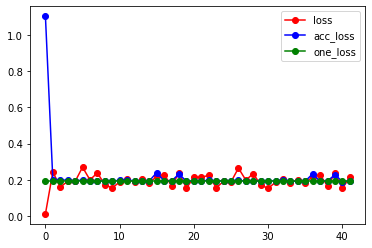

In [69]:
plt.plot(cum_losses, label='loss', color='red', marker='o')
plt.plot(acc_losses, label='acc_loss', color='blue', marker='o')
plt.plot(one_losses, label='one_loss', color='green', marker='o')
plt.legend()

In [70]:
#make test set and test
for length in range(4, 10):
    X, y = generate_data(length)
    print(X)
    print(y)
    X = torch.from_numpy(X)
    X = X.double()
    output = net(X)
    print("Length: ", length, " Output: ", output.item(), " Actual: ", y[-1])

[[0.04339342 0.        ]
 [0.92909215 0.        ]
 [0.29907087 0.        ]
 [0.01761418 0.        ]]
[0. 0. 0. 0.]
Length:  4  Output:  0.9534701262115142  Actual:  0.0
[[0.22631589 1.        ]
 [0.05165469 1.        ]
 [0.67991465 0.        ]
 [0.77890149 0.        ]
 [0.25836924 0.        ]]
[0.22631589 0.27797059 0.27797059 0.27797059 0.27797059]
Length:  5  Output:  0.9898095216283068  Actual:  0.27797058634657934
[[0.4088845  1.        ]
 [0.18381458 1.        ]
 [0.76966694 0.        ]
 [0.98231733 0.        ]
 [0.9602307  0.        ]
 [0.44414616 0.        ]]
[0.4088845  0.59269908 0.59269908 0.59269908 0.59269908 0.59269908]
Length:  6  Output:  1.0120990612776823  Actual:  0.5926990812689994
[[0.01766455 1.        ]
 [0.29260654 0.        ]
 [0.23945715 1.        ]
 [0.32878241 0.        ]
 [0.7465767  0.        ]
 [0.66336757 0.        ]
 [0.10228835 0.        ]]
[0.01766455 0.01766455 0.2571217  0.2571217  0.2571217  0.2571217
 0.2571217 ]
Length:  7  Output:  0.971061346681

In [71]:
loss = accuracy(net, X_test, y_test)
print(loss)

0.19223305865136117


In [72]:
loss_1 = one_accruacy(X_test, y_test)
print(loss_1)

0.1947958533399719
